<a href="https://colab.research.google.com/github/anko00/MachineLearning/blob/main/Week_8_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Support Vector Machines ( Scikit-learn.org )**

## *1. Classification, Maximum margin separating hyperplane*

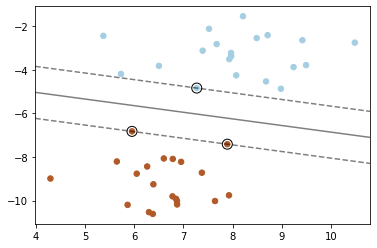

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs


# we create 40 separable points
X, y = make_blobs(n_samples=40, centers=2, random_state=6)

# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel="linear", C=1000)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(
    XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.show()

## *2. Regression, Support Vector Regression (SVR) using linear and non-linear kernels*

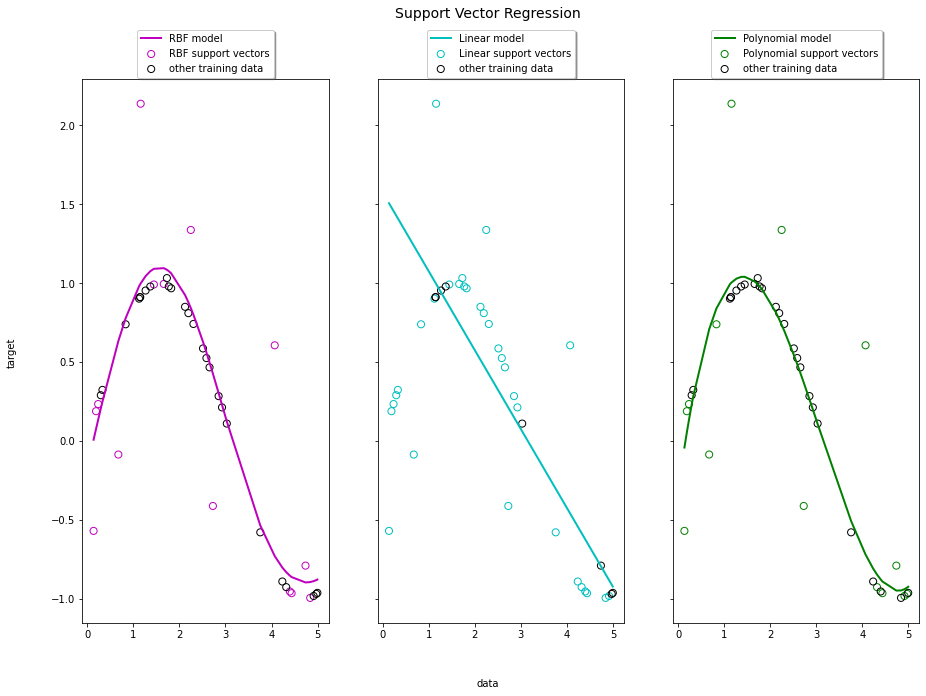

In [7]:
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt

# #############################################################################
# Generate sample data
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()

# #############################################################################
# Add noise to targets
y[::5] += 3 * (0.5 - np.random.rand(8))

# #############################################################################
# Fit regression model
svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_lin = SVR(kernel="linear", C=100, gamma="auto")
svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)

# #############################################################################
# Look at the results
lw = 2

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ["RBF", "Linear", "Polynomial"]
model_color = ["m", "c", "g"]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)
for ix, svr in enumerate(svrs):
    axes[ix].plot(
        X,
        svr.fit(X, y).predict(X),
        color=model_color[ix],
        lw=lw,
        label="{} model".format(kernel_label[ix]),
    )
    axes[ix].scatter(
        X[svr.support_],
        y[svr.support_],
        facecolor="none",
        edgecolor=model_color[ix],
        s=50,
        label="{} support vectors".format(kernel_label[ix]),
    )
    axes[ix].scatter(
        X[np.setdiff1d(np.arange(len(X)), svr.support_)],
        y[np.setdiff1d(np.arange(len(X)), svr.support_)],
        facecolor="none",
        edgecolor="k",
        s=50,
        label="other training data",
    )
    axes[ix].legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.1),
        ncol=1,
        fancybox=True,
        shadow=True,
    )

fig.text(0.5, 0.04, "data", ha="center", va="center")
fig.text(0.06, 0.5, "target", ha="center", va="center", rotation="vertical")
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

## *3. Density estimation, novelty detection. Comparing anomaly detection algorithms for outlier detection on toy datasets*

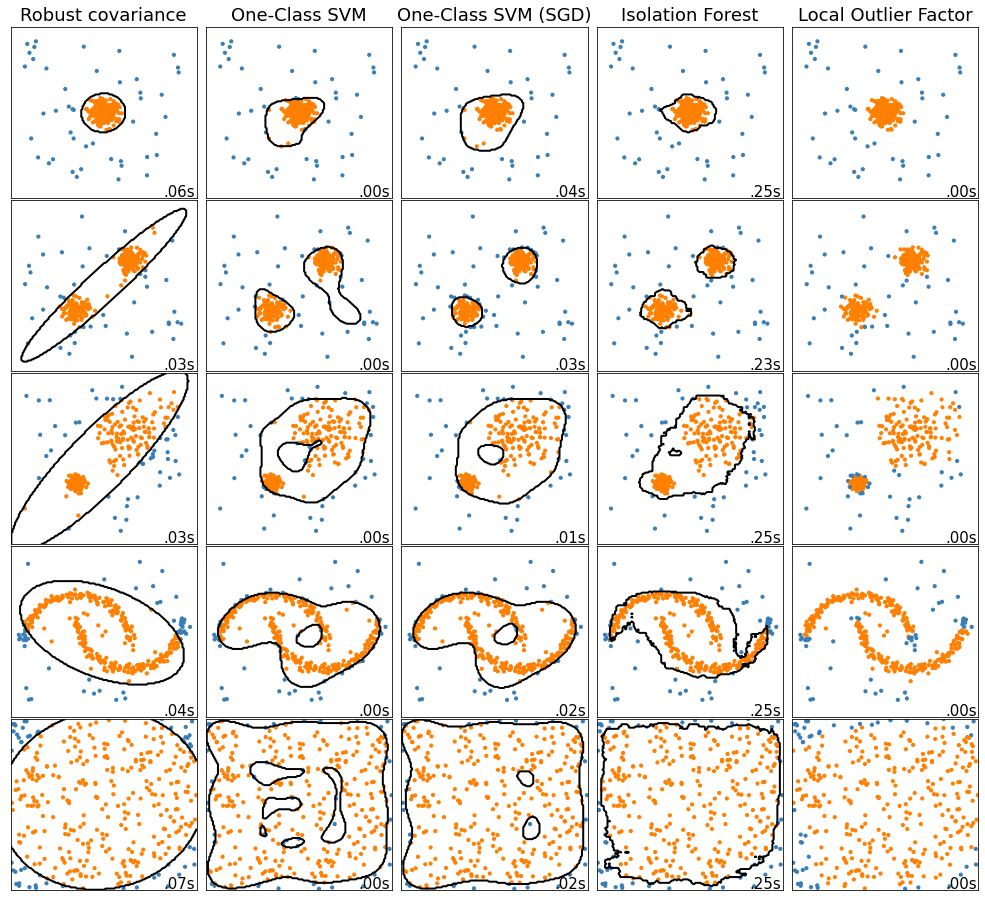

In [8]:
import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

matplotlib.rcParams["contour.negative_linestyle"] = "solid"

# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# define outlier/anomaly detection methods to be compared.
# the SGDOneClassSVM must be used in a pipeline with a kernel approximation
# to give similar results to the OneClassSVM
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
    (
        "One-Class SVM (SGD)",
        make_pipeline(
            Nystroem(gamma=0.1, random_state=42, n_components=150),
            SGDOneClassSVM(
                nu=outliers_fraction,
                shuffle=True,
                fit_intercept=True,
                random_state=42,
                tol=1e-6,
            ),
        ),
    ),
    (
        "Isolation Forest",
        IsolationForest(contamination=outliers_fraction, random_state=42),
    ),
    (
        "Local Outlier Factor",
        LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction),
    ),
]

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, 0.3], **blobs_params)[0],
    4.0
    * (
        make_moons(n_samples=n_samples, noise=0.05, random_state=0)[0]
        - np.array([0.5, 0.25])
    ),
    14.0 * (np.random.RandomState(42).rand(n_samples, 2) - 0.5),
]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 4, 12.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

        colors = np.array(["#377eb8", "#ff7f00"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

## *4. Kernel functions, RBF SVM parameters*

The best parameters are {'C': 1.0, 'gamma': 0.1} with a score of 0.97


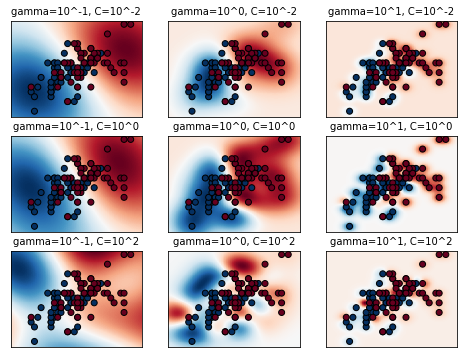

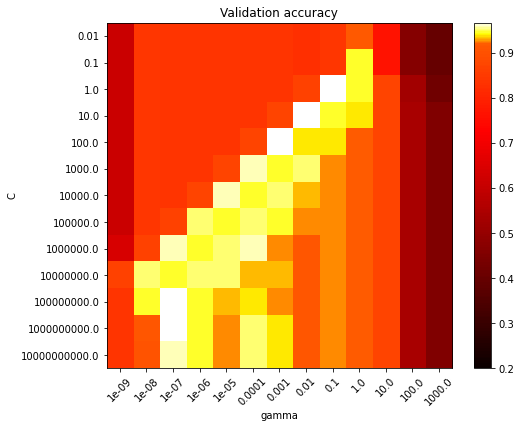

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV


# Utility function to move the midpoint of a colormap to be around
# the values of interest.


class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


# #############################################################################
# Load and prepare data set
#
# dataset for grid search


iris = load_iris()
X = iris.data
y = iris.target

# Dataset for decision function visualization: we only keep the first two
# features in X and sub-sample the dataset to keep only 2 classes and
# make it a binary classification problem.

X_2d = X[:, :2]
X_2d = X_2d[y > 0]
y_2d = y[y > 0]
y_2d -= 1

# It is usually a good idea to scale the data for SVM training.
# We are cheating a bit in this example in scaling all of the data,
# instead of fitting the transformation on the training set and
# just applying it on the test set.

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_2d = scaler.fit_transform(X_2d)

# #############################################################################
# Train classifiers
#
# For an initial search, a logarithmic grid with basis
# 10 is often helpful. Using a basis of 2, a finer
# tuning can be achieved but at a much higher cost.

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

# Now we need to fit a classifier for all parameters in the 2d version
# (we use a smaller set of parameters here because it takes a while to train)

C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf))

# #############################################################################
# Visualization
#
# draw visualization of parameter effects

plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)), size="medium")

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r, edgecolors="k")
    plt.xticks(())
    plt.yticks(())
    plt.axis("tight")

scores = grid.cv_results_["mean_test_score"].reshape(len(C_range), len(gamma_range))

# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(vmin=0.2, midpoint=0.92),
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Validation accuracy")
plt.show()

# **SVM Classifier Tutorial ( kaggle.com )**

In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for statistical data visualization
%matplotlib inline

In [12]:
#https://www.kaggle.com/azzion/svm-for-beginners-tutorial/notebook
#https://www.kaggle.com/gulsahdemiryurek/mobile-price-classification-with-svm
#Mobile Price Classification
#The below topics are covered in this Kernal.

#1. Data prepocessing
#2. Target value Analysis
#3. SVM
#4. Linear SVM
#5. SV Regressor
#6. Non Linear SVM with kernal - RBF ( note: you can also try poly )
#7. Non Linear SVR
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [14]:
# A.DATA PREPROCESSING
# save filepath to variable for easier access
train_file_path = 'latih.csv'
test_file_path = 'tes.csv'
df = pd.read_csv(train_file_path)
test = pd.read_csv(test_file_path)
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [16]:
#B. TARGET VALUE ANALYSIS
#understanding the predicted value - which is hot encoded, in real life price won't be hot encoded.
df['price_range'].describe(), df['price_range'].unique()

# there are 4 classes in the predicted value

(count    2000.000000
 mean        1.500000
 std         1.118314
 min         0.000000
 25%         0.750000
 50%         1.500000
 75%         2.250000
 max         3.000000
 Name: price_range, dtype: float64, array([1, 2, 3, 0]))

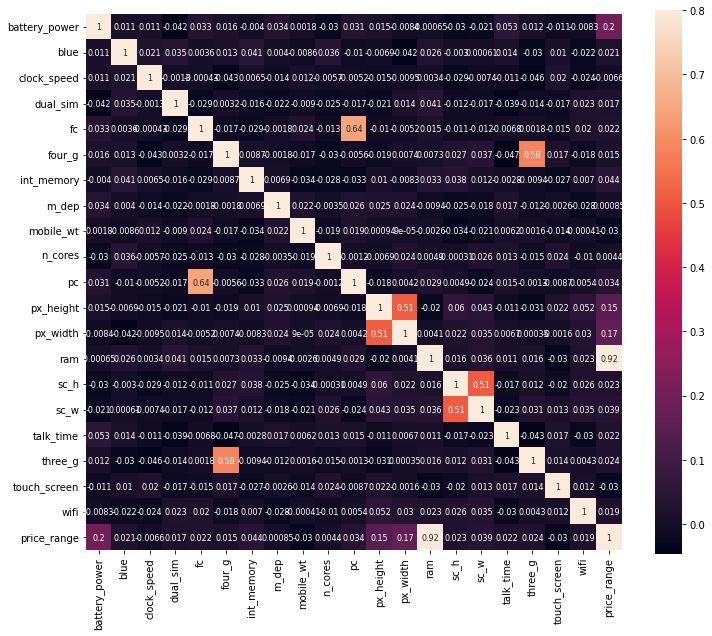

In [17]:
#correlation matrix with heatmap (mencari korelasi antar features, salah satu teknik features selection)
corrmat = df.corr()
f,ax = plt.subplots(figsize=(12,10))
sns.heatmap(corrmat,vmax=0.8,square=True,annot=True,annot_kws={'size':8})

In [18]:
#price range correlation
corrmat.sort_values(by=["price_range"],ascending=False).iloc[0].sort_values(ascending=False)

price_range      1.000000
ram              0.917046
battery_power    0.200723
px_width         0.165818
px_height        0.148858
int_memory       0.044435
sc_w             0.038711
pc               0.033599
three_g          0.023611
sc_h             0.022986
fc               0.021998
talk_time        0.021859
blue             0.020573
wifi             0.018785
dual_sim         0.017444
four_g           0.014772
n_cores          0.004399
m_dep            0.000853
clock_speed     -0.006606
mobile_wt       -0.030302
touch_screen    -0.030411
Name: price_range, dtype: float64

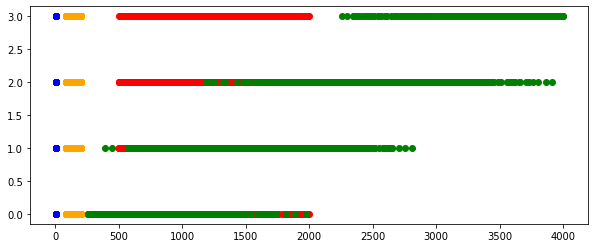

In [19]:
f, ax = plt.subplots(figsize=(10,4))
plt.scatter(y=df['price_range'],x=df['battery_power'],color='red')
plt.scatter(y=df['price_range'],x=df['ram'],color='Green')
plt.scatter(y=df['price_range'],x=df['n_cores'],color='blue')
plt.scatter(y=df['price_range'],x=df['mobile_wt'],color='orange')
# clearly we can see that each of the category has different set of value ranges

In [20]:
# SUPPORT VECTOR MACHINES AND METHODS :
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

y_t = np.array(df['price_range'])
X_t = df
X_t = df.drop(['price_range'],axis=1)
X_t = np.array(X_t)

print("shape of Y :"+str(y_t.shape))
print("shape of X :"+str(X_t.shape))

from sklearn.preprocessing import MinMaxScaler #(scaling rentang 0-1)
scaler = MinMaxScaler()
X_t = scaler.fit_transform(X_t)

shape of Y :(2000,)
shape of X :(2000, 20)


In [21]:
X_train,X_test,Y_train,Y_test = train_test_split(X_t,y_t,test_size=.20,random_state=42)
print("shape of X Train :"+str(X_train.shape))
print("shape of X Test :"+str(X_test.shape))
print("shape of Y Train :"+str(Y_train.shape))
print("shape of Y Test :"+str(Y_test.shape))

shape of X Train :(1600, 20)
shape of X Test :(400, 20)
shape of Y Train :(1600,)
shape of Y Test :(400,)


In [22]:
for this_C in [1,3,5,10,40,60,80,100]: #parameter C di SVM Linier
    clf = SVC(kernel='linear',C=this_C).fit(X_train,Y_train) #clf = cross validate metrics for evaluating classification
    scoretrain = clf.score(X_train,Y_train)
    scoretest  = clf.score(X_test,Y_test)
    print("Linear SVM value of C:{}, training score :{:2f} , Test Score: {:2f} \n".format(this_C,scoretrain,scoretest))

Linear SVM value of C:1, training score :0.953750 , Test Score: 0.960000 

Linear SVM value of C:3, training score :0.961875 , Test Score: 0.977500 

Linear SVM value of C:5, training score :0.968125 , Test Score: 0.975000 

Linear SVM value of C:10, training score :0.977500 , Test Score: 0.967500 

Linear SVM value of C:40, training score :0.981250 , Test Score: 0.962500 

Linear SVM value of C:60, training score :0.981250 , Test Score: 0.962500 

Linear SVM value of C:80, training score :0.981875 , Test Score: 0.970000 

Linear SVM value of C:100, training score :0.980625 , Test Score: 0.967500 



In [23]:
from sklearn.model_selection import cross_val_score,StratifiedKFold,LeaveOneOut
clf1 = SVC(kernel='linear',C=20).fit(X_train,Y_train)
scores = cross_val_score(clf1,X_train,Y_train,cv=5)
strat_scores = cross_val_score(clf1,X_train,Y_train,cv=StratifiedKFold(5,random_state=10,shuffle=True))
#Loo = LeaveOneOut()
#Loo_scores = cross_val_score(clf1,X_train,Y_train,cv=Loo)
print("The Cross Validation Score :"+str(scores))
print("The Average Cross Validation Score :"+str(scores.mean()))
print("The Stratified Cross Validation Score :"+str(strat_scores))
print("The Average Stratified Cross Validation Score :"+str(strat_scores.mean()))
#print("The LeaveOneOut Cross Validation Score :"+str(Loo_scores))
#print("The Average LeaveOneOut Cross Validation Score :"+str(Loo_scores.mean()))

The Cross Validation Score :[0.95     0.9625   0.95     0.925    0.971875]
The Average Cross Validation Score :0.9518749999999999
The Stratified Cross Validation Score :[0.95625  0.95     0.94375  0.971875 0.94375 ]
The Average Stratified Cross Validation Score :0.953125


In [24]:
from sklearn.dummy import DummyClassifier

for strat in ['stratified', 'most_frequent', 'prior', 'uniform']:
    dummy_maj = DummyClassifier(strategy=strat).fit(X_train,Y_train)
    print("Train Stratergy :{} \n Score :{:.2f}".format(strat,dummy_maj.score(X_train,Y_train)))
    print("Test Stratergy :{} \n Score :{:.2f}".format(strat,dummy_maj.score(X_test,Y_test)))

Train Stratergy :stratified 
 Score :0.23
Test Stratergy :stratified 
 Score :0.23
Train Stratergy :most_frequent 
 Score :0.26
Test Stratergy :most_frequent 
 Score :0.23
Train Stratergy :prior 
 Score :0.26
Test Stratergy :prior 
 Score :0.23
Train Stratergy :uniform 
 Score :0.24
Test Stratergy :uniform 
 Score :0.28


In [25]:
# plotting the decision boundries for the data 
#converting the data to array for plotting. 
X = np.array(df.iloc[:,[0,13]])
y = np.array(df['price_range'])
print("Shape of X:"+str(X.shape))
print("Shape of y:"+str(y.shape))
X = scaler.fit_transform(X)

Shape of X:(2000, 2)
Shape of y:(2000,)


In [26]:
# custome color maps
cm_dark = ListedColormap(['#ff6060', '#8282ff','#ffaa00','#fff244','#4df9b9','#76e8fc','#3ad628'])
cm_bright = ListedColormap(['#ffafaf', '#c6c6ff','#ffaa00','#ffe2a8','#bfffe7','#c9f7ff','#9eff93'])

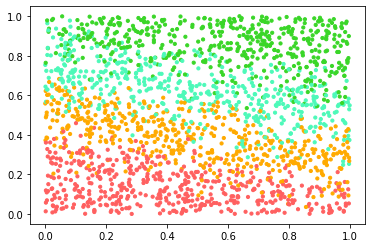

In [27]:
plt.scatter(X[:,0],X[:,1],c=y,cmap=cm_dark,s=10,label=y)
plt.show()

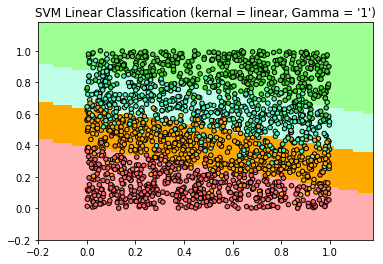

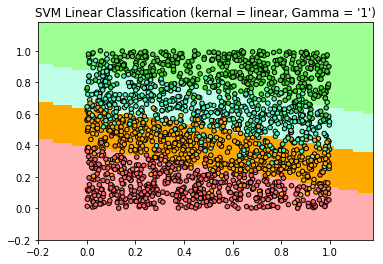

In [28]:
h = .02  # step size in the mesh
C_param = 1 # No of neighbours
for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf1 = SVC(kernel='linear',C=C_param)
    clf1.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min()-.20, X[:, 0].max()+.20
    y_min, y_max = X[:, 1].min()-.20, X[:, 1].max()+.20
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])   # ravel to flatten the into 1D and c_ to concatenate 

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cm_bright)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_dark,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("SVM Linear Classification (kernal = linear, Gamma = '%s')"% (C_param))

plt.show()

In [29]:
print("The score of the above :"+str(clf1.score(X,y)))

The score of the above :0.825


In [30]:
# Linear Support vector machine with only C Parameter 
from sklearn.svm import LinearSVC

for this_C in [1,3,5,10,40,60,80,100]:
    clf2 = LinearSVC(C=this_C).fit(X_train,Y_train)
    scoretrain = clf2.score(X_train,Y_train)
    scoretest  = clf2.score(X_test,Y_test)
    print("Linear SVM value of C:{}, training score :{:2f} , Test Score: {:2f} \n".format(this_C,scoretrain,scoretest))

Linear SVM value of C:1, training score :0.846250 , Test Score: 0.840000 



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Linear SVM value of C:3, training score :0.864375 , Test Score: 0.855000 



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Linear SVM value of C:5, training score :0.867500 , Test Score: 0.870000 



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Linear SVM value of C:10, training score :0.874375 , Test Score: 0.875000 



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Linear SVM value of C:40, training score :0.843125 , Test Score: 0.840000 



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Linear SVM value of C:60, training score :0.822500 , Test Score: 0.840000 



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Linear SVM value of C:80, training score :0.835000 , Test Score: 0.847500 

Linear SVM value of C:100, training score :0.802500 , Test Score: 0.785000 



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [31]:
from sklearn.svm import SVR

svr = SVR(kernel='linear',C=1,epsilon=.01).fit(X_train,Y_train)
print("{:.2f} is the accuracy of the SV Regressor".format(svr.score(X_train,Y_train)))

0.92 is the accuracy of the SV Regressor


In [32]:
#NON LINIER SVM
# SMV with RBF KERNAL AND ONLY C PARAMETER 

for this_C in [1,5,10,25,50,100]:
    clf3 = SVC(kernel='rbf',C=this_C).fit(X_train,Y_train)
    clf3train = clf3.score(X_train,Y_train)
    clf3test  = clf3.score(X_test,Y_test)
    print("SVM for Non Linear \n C:{} Training Score : {:2f} Test Score : {:2f}\n".format(this_C,clf3train,clf3test))

SVM for Non Linear 
 C:1 Training Score : 0.969375 Test Score : 0.862500

SVM for Non Linear 
 C:5 Training Score : 0.998750 Test Score : 0.872500

SVM for Non Linear 
 C:10 Training Score : 1.000000 Test Score : 0.877500

SVM for Non Linear 
 C:25 Training Score : 1.000000 Test Score : 0.877500

SVM for Non Linear 
 C:50 Training Score : 1.000000 Test Score : 0.877500

SVM for Non Linear 
 C:100 Training Score : 1.000000 Test Score : 0.877500



In [33]:
# SVM WITH RBF KERNAL, C AND GAMMA HYPERPARAMTER 
for this_gamma in [.1,.5,.10,.25,.50,1]:
    for this_C in [1,5,7,10,15,25,50]:
        clf3 = SVC(kernel='rbf',C=this_C,gamma=this_gamma).fit(X_train,Y_train)
        clf3train = clf3.score(X_train,Y_train)
        clf3test  = clf3.score(X_test,Y_test)
        print("SVM for Non Linear \n Gamma: {} C:{} Training Score : {:2f} Test Score : {:2f}\n".format(this_gamma,this_C,clf3train,clf3test))

SVM for Non Linear 
 Gamma: 0.1 C:1 Training Score : 0.928750 Test Score : 0.902500

SVM for Non Linear 
 Gamma: 0.1 C:5 Training Score : 0.965000 Test Score : 0.907500

SVM for Non Linear 
 Gamma: 0.1 C:7 Training Score : 0.971250 Test Score : 0.912500

SVM for Non Linear 
 Gamma: 0.1 C:10 Training Score : 0.979375 Test Score : 0.907500

SVM for Non Linear 
 Gamma: 0.1 C:15 Training Score : 0.986875 Test Score : 0.905000

SVM for Non Linear 
 Gamma: 0.1 C:25 Training Score : 0.991250 Test Score : 0.920000

SVM for Non Linear 
 Gamma: 0.1 C:50 Training Score : 0.998125 Test Score : 0.910000

SVM for Non Linear 
 Gamma: 0.5 C:1 Training Score : 0.980625 Test Score : 0.835000

SVM for Non Linear 
 Gamma: 0.5 C:5 Training Score : 1.000000 Test Score : 0.850000

SVM for Non Linear 
 Gamma: 0.5 C:7 Training Score : 1.000000 Test Score : 0.847500

SVM for Non Linear 
 Gamma: 0.5 C:10 Training Score : 1.000000 Test Score : 0.847500

SVM for Non Linear 
 Gamma: 0.5 C:15 Training Score : 1.0000

In [34]:
# grid search method 
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [1,5,7,10,15,25,50],
              'gamma': [.1,.5,.10,.25,.50,1]}
GS = GridSearchCV(SVC(kernel='rbf'),param_grid,cv=5)

In [35]:
GS.fit(X_train,Y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 5, 7, 10, 15, 25, 50],
                         'gamma': [0.1, 0.5, 0.1, 0.25, 0.5, 1]})

In [36]:
print("the parameters {} are the best.".format(GS.best_params_))
print("the best score is {:.2f}.".format(GS.best_score_))

the parameters {'C': 7, 'gamma': 0.1} are the best.
the best score is 0.90.


In [37]:
# Kernalized SVM machine 
svr2 = SVR(degree=2,C=100,epsilon=.01).fit(X_train,Y_train)
print("{:.2f} is the accuracy of the SV Regressor".format(svr2.score(X_train,Y_train)))

1.00 is the accuracy of the SV Regressor


In [38]:
test = test.drop(['id'],axis=1)
test.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0
1,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0
2,1807,1,2.8,0,1,0,27,0.9,186,3,4,1270,1366,2396,17,10,10,0,1,1
3,1546,0,0.5,1,18,1,25,0.5,96,8,20,295,1752,3893,10,0,7,1,1,0
4,1434,0,1.4,0,11,1,49,0.5,108,6,18,749,810,1773,15,8,7,1,0,1


In [39]:
test_mat = np.array(test)
test = scaler.fit_transform(test_mat)

In [40]:
clf4 = SVC(kernel='rbf',C=25,gamma=.1).fit(X_train,Y_train)
prediction = clf4.predict(test_mat)
pred = pd.DataFrame(prediction)
pred.head()
pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       1000 non-null   int64
dtypes: int64(1)
memory usage: 7.9 KB


In [41]:
prediction = svr2.predict(test_mat)
pred = pd.DataFrame(prediction)
pred.head()

,0
0,1.443312
1,1.443312
2,1.443312
3,1.443312
4,1.443312
